### Default of credit card clients (Classification)

#### by Josh Starmer from StatQuest

#### Data Set Information:
This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default.

#### Attribute Information:
`This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. `

This study reviewed the literature and used the following 23 variables as explanatory variables:
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [38]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [3]:
# Loading the data
df_raw = pd.read_excel('data/credit_card_clients.xls', header = 1)

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
df_raw.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


In [6]:
# Let's make a copy of the raw df to leave it untouched
df_eda = df_raw.copy()

In [7]:
# We can drop ID column because it has no value for the model
df_eda.drop('ID', axis =1, inplace = True)

In [8]:
# We can also change the name of last column to make it easier to use
df_eda.rename(columns={'default payment next month': 'DEFAULT'}, inplace = True)

In [9]:
# Let's see the basic information
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [10]:
df_eda.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### No missing values but ....

There are some inconsistencies with the description and the data:
* Education - according to the descritption there should be values 1 to 4 but there are more of them (like 0 or 6)
* Marriage - according to the description there should be values 1 to 3 but there is also 0
* PAY - The minimum value should be -1, but there is also -2 which is not described

Let's check it in details ..

In [11]:
df_eda.EDUCATION.unique(), df_eda.MARRIAGE.unique()

(array([2, 1, 3, 5, 4, 6, 0], dtype=int64), array([1, 2, 3, 0], dtype=int64))

In [12]:
df_eda.PAY_0.unique(), df_eda.PAY_2.unique(), df_eda.PAY_3.unique(), df_eda.PAY_4.unique(), df_eda.PAY_5.unique(), df_eda.PAY_6.unique()

(array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6], dtype=int64),
 array([ 2,  0, -1, -2,  3,  5,  7,  4,  1,  6,  8], dtype=int64),
 array([-1,  0,  2, -2,  3,  4,  6,  7,  1,  5,  8], dtype=int64),
 array([-1,  0, -2,  2,  3,  4,  5,  7,  6,  1,  8], dtype=int64),
 array([-2,  0, -1,  2,  3,  5,  4,  7,  8,  6], dtype=int64),
 array([-2,  2,  0, -1,  3,  6,  4,  7,  8,  5], dtype=int64))

We can do different thigs with that data:

* Remove 0 from Education and Marriage assuming that those are missing values
* Assume that 0 in Education means "no education" and leave it like that
* Remove all of the data that is not described assuming that this is some data added by mistake
* To compare the results we can prepare couple of df copies using what I mentioned above 

I did some reading and if it is about PAY columns I have found on `Kaggle` explanation of the values that are not described in ML Repository and here is the full description:

`-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months`

So if it is about those columns they will be left untouched.

Before we decide let's see some more numbers...

In [13]:
df_eda.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

We have 54 rows with Marriage marked as 0 so it is less than 2% of the data. We can remove those values with no harm to the dataset.

In [14]:
df_eda['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

We have only 14 rows with Education marked as 0 so together with 0's in Marriage that gives us about 2% of the data. My first try would be to remove 0's in both of the columns and see the results.

In [15]:
# Let's make a df with no 0's at those two columns
df_1 = df_eda.loc[(df_eda.EDUCATION != 0) & (df_eda.MARRIAGE != 0)]

#### Because SVM doesn't do well on big datasets we can try downsampling the data using sklearn resample

First of all we will make two separate df's (one with default=0 and second with default=1) to make sure that the resulting dataset will be balanced.

In [16]:
df_1_no_default = df_1[df_1['DEFAULT'] == 0]
df_1_default = df_1[df_1['DEFAULT'] == 1]

In [17]:
no_default_downsampled = resample(df_1_no_default,
                                  replace = False,
                                  n_samples = 1000,
                                  random_state = 42)

default_downsampled = resample(df_1_default,
                                  replace = False,
                                  n_samples = 1000,
                                  random_state = 42)

df_1_downsampled = pd.concat([no_default_downsampled, default_downsampled])

len(df_1_downsampled)

2000

#### Now we can split the df into X and y and continue preparing the data for SVM

In [18]:
X_down = df_1_downsampled.drop("DEFAULT", axis =1).copy()

In [19]:
y_down = df_1_downsampled['DEFAULT'].copy()

#### One-hot-encoding using pandas get_dummies

In [20]:
X_encoded = pd.get_dummies(X_down, columns=['SEX',
                                            'EDUCATION',
                                            'MARRIAGE',
                                            'PAY_0',
                                            'PAY_2',
                                            'PAY_3',
                                            'PAY_4',
                                            'PAY_5',
                                            'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_7,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Splitting the data into training and testing

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_down, test_size = 0.2, random_state = 42)

#### Standardizing the data with StandardScaler()

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [23]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Building a SVM classifier

In [24]:
clf = SVC(random_state=42)
clf.fit(X_train_scaled, y_train)

SVC(random_state=42)

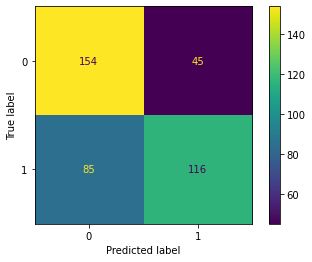

In [25]:
predictions = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = clf.classes_)
disp.plot();

#### Optimization 

In [26]:
param_grid = [{ 'C': [0.5, 1, 10, 100, 1000],
                'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}]

optimal_params = GridSearchCV(SVC(),
                              param_grid,
                              scoring = 'accuracy')

optimal_params.fit(X_train_scaled, y_train)                              

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.5, 1, 10, 100, 1000],
                          'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [27]:
optimal_params.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

#### Building Support Vector Machine Classifier using best parameters

In [28]:
clf_best = SVC(C = 1,
               gamma = 0.01,
               kernel = 'rbf',
               random_state = 42)
clf_best.fit(X_train_scaled, y_train)

SVC(C=1, gamma=0.01, random_state=42)

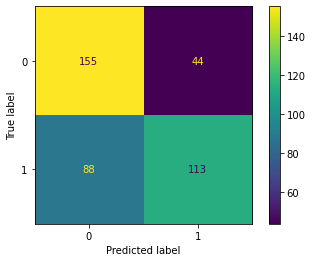

In [29]:
best_predictions = clf_best.predict(X_test_scaled)
cm_best = confusion_matrix(y_test, best_predictions, labels=clf_best.classes_)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best,
                                   display_labels = clf_best.classes_)
disp_best.plot();

#### Scaling and plotting the results

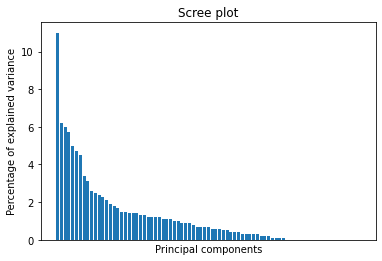

In [30]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(axis = 'x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)

plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal components')
plt.title('Scree plot')
plt.show();


The scree plot shows that the first principal component (pc1) accounts for relatively large amount of variation in the raw data and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. However pc2 is pretty much the same as pc3, pc4 which doesn't bode well for dimension reduction. What we would like to see it for those two columns to stand out on top of other results. 

The next step is to draw the PCA graph. Let's do that with the results we got.

## The PCA graph

### In here we are retraining the SVM on just those two first columns from scree plot 

In [34]:
# pc1 contains x-axis coordinates of the data after PCA
# pc2 contains y-axis coordinates of the data after PCA
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]

# Centering and scaling the data
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Optimizing the SVM fit to the x and y-axis coordinates
param_grid = [{'C': [1, 10, 100, 1000],
               'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf']}]

optimal_params = GridSearchCV(SVC(),
                              param_grid,
                              cv = 5,
                              scoring = 'accuracy',
                              verbose = 0)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


Even though gamma in the results is 1 we will use 0.001 to make the graph clearer and easier to explain

### Drawing the graph

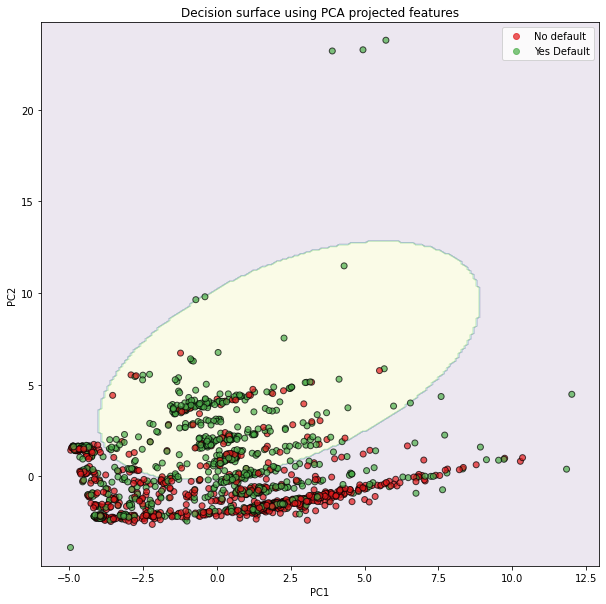

In [42]:
clf = SVC(random_state = 42, gamma = 0.001, C = 1000)
clf.fit(pca_train_scaled, y_train)

# Transforming dataset with PCA
X_test_pca = pca.transform(X_train_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# Creating a matrix of points to be used to show decision regions.
# The matrix will be a little bit larger than the transformed PCA points 
# so that we can plot all of the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1
y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start = x_min, stop = x_max, step = 0.1),
                     np.arange(start = y_min, stop = y_max, step = 0.1))

# Classifying every point in matrix with SVM
# Points on the side of the classification boundary will get 0
# Points on the other side will get 1
Z = clf.predict(np.column_stack((xx.ravel(), yy.ravel())))

# Right now X is just a long array of 0's and 1's which reflect how each point in the mesh was classified.
# We use reshape() so that each classification (0 or 1) corresponds to a specific point in matrix
Z = Z.reshape(xx.shape)

fig,ax = plt.subplots(figsize = (10,10))

# We will use contourf() to draw a filled contour plot using matrix values and classifications.
# The contours will be filled according to the predicted classifications (0's and 1's) in Z
ax.contourf(xx, yy, Z, alpha = 0.1)

# Creating custom colors for actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

# Drawing actual points - colored by their known (not predicted) classifications
# Setting alpha to 0.7 lets us see if we are covering up a point
scatter = ax.scatter(test_pc1_coords, 
                     test_pc2_coords, 
                     c = y_train,
                     cmap = cmap, 
                     edgecolors = 'k',
                     alpha = 0.7)

# Legend
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                   loc = "upper right")
legend.get_texts()[0].set_text("No default")
legend.get_texts()[1].set_text("Yes Default")

# Axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using PCA projected features')

plt.show();

The light purple on the graph is the area were all datapoints will be predicter to have not defaulted. The yellow part of the graph is the area where all datapoints will be predicted to have defaulted.The dots are datapoints in the training dataset (red for those that did not default and green for those that defaulted).

The results are showing the training data not testing data. We only fit the SVM to the first two principal components not all of them so it is only an approximation of the true classifier. Because PC2 was very similar to PC3 or PC4 this is not very good approximation.